# Late Fusion: Audio Model Interpretation

## Setup

In [1]:
import os
from glob import glob
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy
from treeinterpreter import treeinterpreter as ti

/usr/local/Caskroom/miniconda/base/envs/kth/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


### Paths

In [2]:
input_path = '../../../2.data_preparation/out/audio/'
output_path = '../out/audio/'
# Global configuration path
glob_conf_path = '../../../config/global_config.py'

### Load global variables

In [3]:
exec(open(glob_conf_path).read())

## Model interpretation

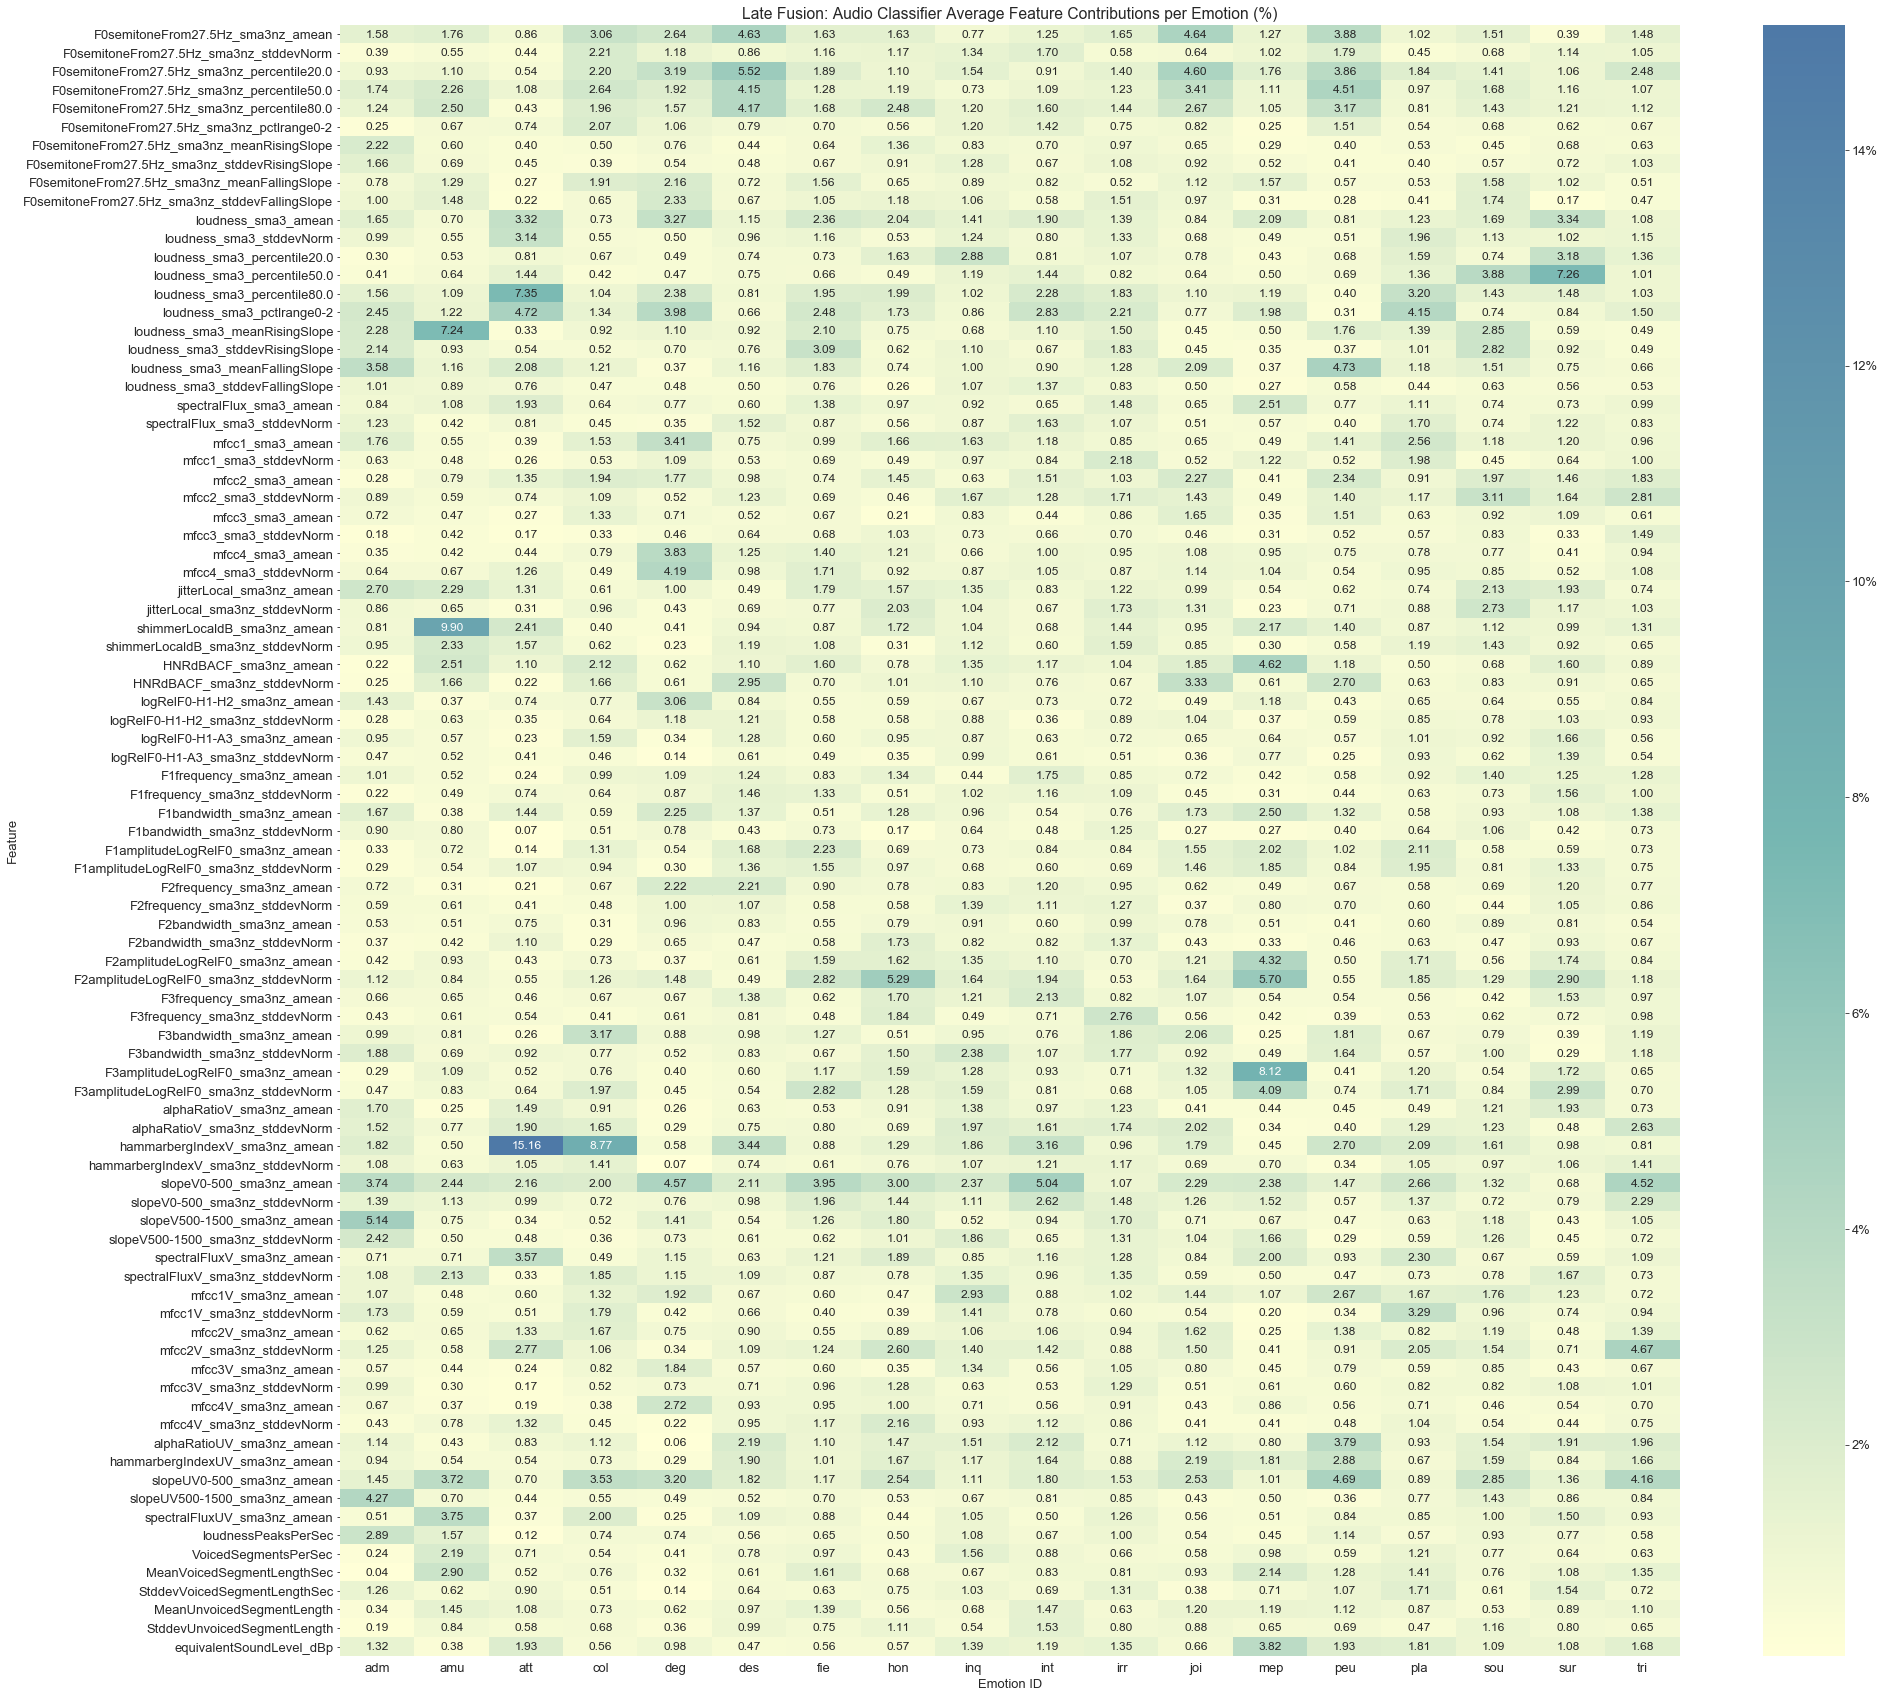

In [17]:
# Load the data
train_egemaps_df = pd.read_csv(os.path.join(input_path, 'egemaps', 'audio_data_egemaps_late_fusion_train.csv'))
test_egemaps_df = pd.read_csv(os.path.join(input_path, 'egemaps', 'audio_data_egemaps_late_fusion_test.csv'))

# Load min_max_scaler_egemaps
file_path = os.path.join(input_path,'egemaps','min_max_scaler_egemaps_audio.sav')
min_max_scaler_egemaps = pickle.load(open(file_path, 'rb'))

# Normalize data
X_normalized = min_max_scaler_egemaps.transform(test_egemaps_df.drop(columns='target'))
X_test = pd.DataFrame(data=X_normalized, columns=test_egemaps_df.drop(columns='target').columns)
y_test = test_egemaps_df.target


# Load the model from disk
file_path = os.path.join(output_path,'models','mod_rf_egemaps_audio.sav')
clf = pickle.load(open(file_path, 'rb'))
#importances = clf.feature_importances_


# Step 0. Get bias, contribution and predicted class and store it in a dataframe
prediction_proba, bias, contributions = ti.predict(clf, X_test)
prediction = clf.predict(X_test)
data_tmp = []
for i in range(len(X_test)):
    pred_class = prediction[i]
    bias_tmp = bias[i,pred_class]
    contributions_tmp = contributions[i,:,pred_class]
    data_tmp.append([bias_tmp] + contributions_tmp.tolist() + [pred_class])
#interpretation_step_0_df = pd.DataFrame(data=data_tmp, columns=['bias']+[feature + '_contribution' for feature in X_test.columns.tolist()]+['prediction']) 
interpretation_step_0_df = pd.DataFrame(data=data_tmp, columns=['bias']+X_test.columns.tolist()+['prediction']) 

# Step 1. Get abs value of contributions
interpretation_step_1_df = interpretation_step_0_df.copy()
columns_to_abs = interpretation_step_1_df.drop(columns='prediction').columns.tolist()
interpretation_step_1_df[columns_to_abs] = interpretation_step_1_df[columns_to_abs].abs()

# Step 2. Group by predicted class and calculate mean
interpretation_step_2_df = interpretation_step_1_df.groupby('prediction').mean().reset_index()

# Step 3. Get normalized contribution (%)
interpretation_step_3_df = interpretation_step_2_df.copy().drop(columns='bias')
columns_to_perc = interpretation_step_3_df.drop(columns='prediction').columns.tolist()
interpretation_step_3_df[columns_to_perc] = 100 * interpretation_step_3_df[columns_to_perc].div(interpretation_step_3_df[columns_to_perc].sum(axis=1),axis=0)
interpretation_step_3_df['emotion_id'] = interpretation_step_3_df['prediction'].map(emotion_num_to_emotion_id)
interpretation_step_3_df = interpretation_step_3_df.drop(columns='prediction')

# Plot results
mat = interpretation_step_3_df.set_index(keys='emotion_id').transpose()
sns.set_style({'ytick.left': True})
plt.figure(figsize=(30,30))
ax = sns.heatmap(mat, annot=True, annot_kws={"size": 12}, fmt='.2f', cmap=conf_cmap)
cbar = ax.collections[0].colorbar
cbar.set_ticks(cbar.get_ticks())
cbar.set_ticklabels([str(int(i))+'%' for i in cbar.get_ticks()])
#plt.yticks(va='center')
plt.xlabel('Emotion ID')
plt.ylabel('Feature')
plt.savefig(os.path.join(output_path,'others','report_audio_classifier_feature_contributions.svg'), bbox_inches = 'tight')
plt.title('Late Fusion: Audio Classifier Average Feature Contributions per Emotion (%)')
plt.savefig(os.path.join(output_path,'others','audio_classifier_feature_contributions.svg'), bbox_inches = 'tight')
#plt.show()